In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %%
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".90"
os.environ["JAX_PLATFORMS"] = "cuda"  # change to 'cpu' if no GPU is available


from datasets import load_dataset

import grain

import jax
from jax import numpy as jnp

import numpy as np

from flax import nnx

from gensbi.experimental.models.autoencoders import AutoEncoder1D, AutoEncoderParams, vae_loss_fn
from gensbi.experimental.models.autoencoders.commons import Loss

import optax

from tqdm import tqdm

import matplotlib.pyplot as plt

from gensbi.utils.plotting import plot_marginals
import gc

In [3]:
repo_name = "aurelio-amerio/SBI-benchmarks"

task_name = "gravitational_waves"

# dataset = load_dataset(repo_name, task_name).with_format("numpy")
dataset = load_dataset(repo_name, task_name, cache_dir="/data/users/.cache").with_format("numpy")


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

In [4]:
# df_train = {"xs": np.array(dataset["train"]["xs"]), "thetas": np.array(dataset["train"]["thetas"])}
# df_val = {"xs": np.array(dataset["validation"]["xs"]), "thetas": np.array(dataset["validation"]["thetas"])}
# df_test = {"xs": np.array(dataset["test"]["xs"]), "thetas": np.array(dataset["test"]["thetas"])}
df_train = dataset["train"]
df_val = dataset["validation"]
df_test = dataset["test"]

In [5]:
# compute the mean of xs and thetas
xs_mean = jnp.array([[[ 0.00051776, -0.00040733]]], dtype=jnp.bfloat16) #np.mean(df_train["xs"], axis=(0,1), keepdims=True)
thetas_mean = jnp.array([[44.826576, 45.070328]], dtype=jnp.bfloat16) #np.mean(df_train["thetas"], axis=0, keepdims=True)

xs_std = jnp.array([[[60.80799, 59.33193]]], dtype=jnp.bfloat16) #np.std(df_train["xs"], axis=(0,1), keepdims=True)
thetas_std = jnp.array([[20.189356, 20.16127 ]], dtype=jnp.bfloat16) #np.std(df_train["thetas"], axis=0, keepdims=True)


W1230 18:23:09.145843 1294316 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1230 18:23:09.151557 1294178 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [6]:
def normalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return (batch - mean) / std

def unnormalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return batch * std + mean

In [7]:
# we define a CNN to embed the data
class ConvEmbed(nnx.Module):
    def __init__(self, dim_cond, ch_cond, *, rngs):
        features = 16
        padding = "SAME"
        self.activation = jax.nn.gelu
        dlin = dim_cond
        conv1 = nnx.Conv(ch_cond, features, kernel_size=(9,), strides=2, padding=padding, rngs=rngs, param_dtype=jnp.bfloat16) # 512
        dlin = dlin//2
        bn1 = nnx.BatchNorm(features, rngs=rngs, param_dtype=jnp.bfloat16)
        conv2 = nnx.Conv(features, features*2, kernel_size=(6,), strides=2, padding=padding, rngs=rngs, param_dtype=jnp.bfloat16) # 256
        dlin = dlin//2
        features *= 2
        bn2 = nnx.BatchNorm(features, rngs=rngs, param_dtype=jnp.bfloat16)
        conv3 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs, param_dtype=jnp.bfloat16) # 128
        dlin = dlin//2
        features *= 2
        bn3 = nnx.BatchNorm(features, rngs=rngs, param_dtype=jnp.bfloat16)
        conv4 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs, param_dtype=jnp.bfloat16) # 64
        dlin = dlin//2
        features *= 2
        bn4 = nnx.BatchNorm(features, rngs=rngs, param_dtype=jnp.bfloat16)
        conv5 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs, param_dtype=jnp.bfloat16) # 32
        dlin = dlin//2
        features *= 2
        bn5 = nnx.BatchNorm(features, rngs=rngs, param_dtype=jnp.bfloat16)
        conv6 = nnx.Conv(features, features, kernel_size=(3,), strides=2, padding=padding, rngs=rngs, param_dtype=jnp.bfloat16) # 16
        dlin = dlin//2
        bn6 = nnx.BatchNorm(features, rngs=rngs, param_dtype=jnp.bfloat16)
        conv7 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs, param_dtype=jnp.bfloat16) # 8
        dlin = dlin//2
        features*=2
        bn7 = nnx.BatchNorm(features, rngs=rngs, param_dtype=jnp.bfloat16)
        conv8 = nnx.Conv(features, features, kernel_size=(3,), strides=2, padding=padding, rngs=rngs, param_dtype=jnp.bfloat16) # 4
        dlin = dlin//2
        bn8 = nnx.BatchNorm(features, rngs=rngs, param_dtype=jnp.bfloat16)
        
        self.latent_shape = (1, dlin, features)

        self.conv_layers = nnx.List([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8])
        self.bn_layers = nnx.List([bn1, bn2, bn3, bn4, bn5, bn6, bn7, bn8])

        # self.linear = nnx.Linear(int(dlin), dout, rngs=rngs)
    
    def __call__(self, x):
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            x = self.activation(x)
            x = self.bn_layers[i](x)
        
        # #flatten x
        # x = x.reshape(x.shape[0], -1)
        # x = self.linear(x)
        
        # return x[..., None,:]
        return x

# now we create the flow pipeline

In [8]:
from gensbi.models import Flux1Params, Flux1
from gensbi.recipes import ConditionalFlowPipeline

from jax import Array



In [9]:
dim_obs = 2
dim_cond = 8192
ch_obs = 1
ch_cond = 2
z_ch = 512
dim_cond_latent = 32
dim_joint = dim_obs + dim_cond_latent 


In [ ]:
params_flux = Flux1Params(
        in_channels=ch_obs,
        vec_in_dim=None,
        context_in_dim=z_ch,
        mlp_ratio=4,
        num_heads=4,
        depth=4,
        depth_single_blocks=8,
        axes_dim=[
            20,
        ],
        dim_obs=dim_obs,
        dim_cond=dim_cond_latent,
        theta = 10 * dim_joint,
        qkv_bias=True,
        guidance_embed=False,
        rngs=nnx.Rngs(0),
        param_dtype=jnp.bfloat16,
    )

In [11]:
# now we create a model which joins the vae encoder and the sbi model
# first we delete the decoder, as we won't need it 


In [11]:

class GWModel(nnx.Module):
    def __init__(self, encoder, sbi_model):
        self.encoder = encoder
        self.sbi_model = sbi_model

    def __call__(
        self,
        t: Array,
        obs: Array,
        obs_ids: Array,
        cond: Array,
        cond_ids: Array,
        conditioned: bool | Array = True,
        guidance: Array | None = None,
    ):
        # first we encode the conditioning data
        cond_latent = self.encoder(cond)

        # then we pass to the sbi model
        return self.sbi_model(
            t=t,
            obs=obs,
            obs_ids=obs_ids,
            cond=cond_latent,
            cond_ids=cond_ids,
            conditioned=conditioned,
            guidance=guidance,
        )


In [12]:
encoder = ConvEmbed(dim_cond, ch_cond, rngs=nnx.Rngs(0))

In [13]:
model_sbi = Flux1(params_flux)

In [14]:
model = GWModel(encoder, model_sbi)

In [16]:
def split_data(batch):
    obs = jnp.array(batch["thetas"],dtype=jnp.bfloat16)
    obs = normalize(obs, thetas_mean, thetas_std)
    obs = jnp.deg2rad(obs)
    obs = obs.reshape(obs.shape[0], dim_obs, ch_obs)
    
    cond = jnp.array(batch["xs"],dtype=jnp.bfloat16)
    cond = normalize(cond, xs_mean, xs_std)
    return obs, cond

In [17]:
batch_size = 512

train_dataset_npe = (
        grain.MapDataset.source(df_train)
        .shuffle(42)
        .repeat()
        .to_iter_dataset()
        # .batch(batch_size)
        # .map(split_data)
        # .mp_prefetch()
    )

performance_config = grain.experimental.pick_performance_config(
    ds=train_dataset_npe,
    ram_budget_mb=1024 * 8,
    max_workers=None,
    max_buffer_size=None,
)

train_dataset_npe = (
    train_dataset_npe.batch(batch_size)
    .map(split_data)
    # .mp_prefetch(performance_config.multiprocessing_options)
)

val_dataset_npe = (
            grain.MapDataset.source(df_val)
            .shuffle(42)
            .repeat()
            .to_iter_dataset()
            .batch(batch_size)
            .map(split_data)
        )

In [18]:
iter_train_npe = iter(train_dataset_npe)
obs_, cond_ = next(iter_train_npe)

In [19]:
obs_.shape, cond_.shape

((512, 2, 1), (512, 8192, 2))

In [20]:
training_config = ConditionalFlowPipeline._get_default_training_config()
training_config["checkpoint_dir"] = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/tests/gw_npe_v3/checkpoints"
training_config["experiment_id"] = 1

pipeline_latent = ConditionalFlowPipeline(
        model,
        train_dataset_npe,
        val_dataset_npe,
        dim_obs=dim_obs,
        dim_cond=dim_cond_latent,  # we are workin in the latent space of the vae
        ch_obs=ch_obs,
        ch_cond=z_ch,  # conditioning is now in the latent space
        training_config=training_config,
    )

In [21]:
pipeline_latent.train(nnx.Rngs(0), nsteps=50, save_model=False)
# pipeline_latent.restore_model()

100%|██████████| 50/50 [02:46<00:00,  3.32s/it]


([], [])

In [21]:
val_dataset_NPE_iter = iter(val_dataset_npe)
batch = next(val_dataset_NPE_iter)

In [22]:
true_thetas, xs_o = batch

In [23]:
true_theta = true_thetas[42]
x_o = xs_o[42][None,...]

In [24]:
x_o.shape, true_theta.shape

((1, 8192, 2), (1, 2))

In [25]:
samples = pipeline_latent.sample(nnx.Rngs(0).sample(), x_o, 1_000)

In [26]:
res = samples[:,0,:]

<Figure size 640x480 with 0 Axes>

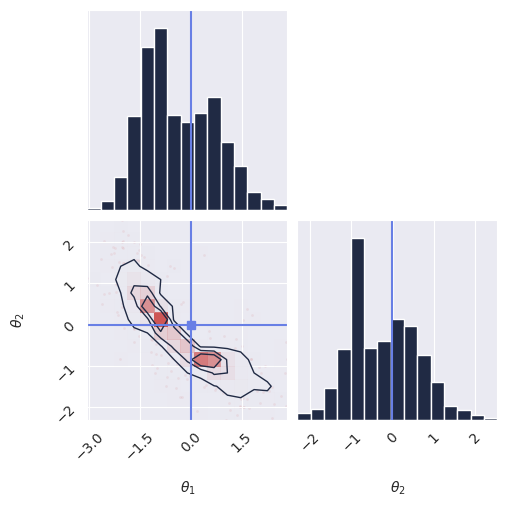

In [27]:
# plot_marginals(res, true_param=true_theta[0], gridsize=20, range=[(0.8,1.2),(0,2)])
plot_marginals(res, true_param=true_theta[0])
plt.show()

# Calibration tests

In [28]:
# imports
from gensbi_validation import PosteriorWrapper
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp
from sbi.analysis.plot import plot_tarp

import torch

In [29]:
posterior = PosteriorWrapper(pipeline_latent, rngs=nnx.Rngs(1234), theta_shape=(1,2), x_shape=(8192,2))
# posterior = PosteriorWrapper(pipeline_latent, rngs=nnx.Rngs(1234))

In [30]:
dataset["test"]

Dataset({
    features: ['xs', 'thetas'],
    num_rows: 10000
})

In [31]:
# key = jax.random.PRNGKey(1234)
# sample the dataset
test_data = dataset["test"]

# split in thetas and xs
thetas = np.array(test_data["thetas"])[:200] # (200, 3, 1)
xs = np.array(test_data["xs"])[:200] # (200, 3, 1)

In [32]:
# flatten the dataset. sbi expects 2D arrays of shape (num_samples, features), while our data is 3D of shape (num_samples, dim, channels).
# we reshape a sample of size (dim, channels) into a vector of size (dim * channels)
thetas_ = posterior._ravel(thetas) # (200, 3)
xs_ = posterior._ravel(xs) # (200, 3)

# convert to torch tensors
thetas_torch = torch.Tensor(np.asarray(thetas_, dtype=np.float32))
xs_torch = torch.Tensor(np.asarray(xs_, dtype=np.float32))

In [33]:
batches = posterior.sample_batched((100,), xs_torch, chunk_size=50)

E1229 00:47:10.885330  934120 slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %conv_general_dilated.3 = f32[200,512,128]{2,1,0} convolution(%constant.1270, %constant.801), window={size=3 stride=2 pad=0_1}, dim_labels=b0f_0io->b0f, metadata={op_name="jit(batched_sampler)/while/body/closed_call/vmap(jit(sampler))/jit(diffeqsolve)/outer-loop/checkpointed-no-vjp/while/body/checkpointed-no-vjp/while/body/conv_general_dilated" source_file="/home/zaldivar/Documents/Aurelio/Github/GenSBI/src/gensbi/flow_matching/solver/ode_solver.py" source_line=95 source_end_line=108 source_column=23 source_end_column=13}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dum

In [ ]:
batches = posterior.sample_batched((100,), xs_torch, chunk_size=None)

In [52]:
thetas_torch.shape, xs_torch.shape

(torch.Size([200, 2]), torch.Size([200, 16384]))

In [53]:
ecp, alpha = run_tarp(
    thetas_torch[:20],
    xs_torch[:20],
    posterior,
    references=None,  # will be calculated automatically.
    num_posterior_samples=100, # reduce this number to 1000 if you go OOM
)

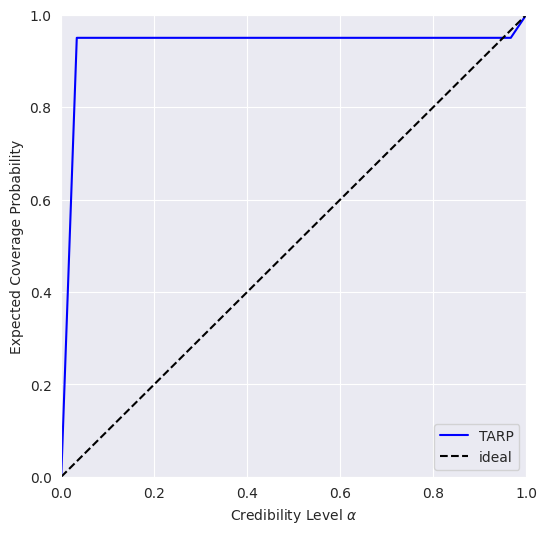

In [ ]:
plot_tarp(ecp, alpha)
# plt.savefig("flux1_flow_pipeline_tarp.png", dpi=100, bbox_inches="tight") # uncomment to save the figure
plt.show()